# Интерполяция сплайнами

In [429]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
import numpy as np

In [444]:
class NaturalCubicSpline(BaseEstimator, TransformerMixin):
    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self.n_params
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    @property
    def n_params(self):
        return self.n_knots - 1
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
            
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t):
                return np.maximum(0, t)
            
            numerator = (ppart(x - self.knots[knot_idx])**3 - ppart(x - self.knots[self.n_knots - 1])**3)
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

In [445]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p

In [446]:
def f(x):
    return np.sin(x) * x

In [447]:
x = np.linspace(-1, 20, 100)
y = f(x) + np.random.normal(0, 2, len(x))

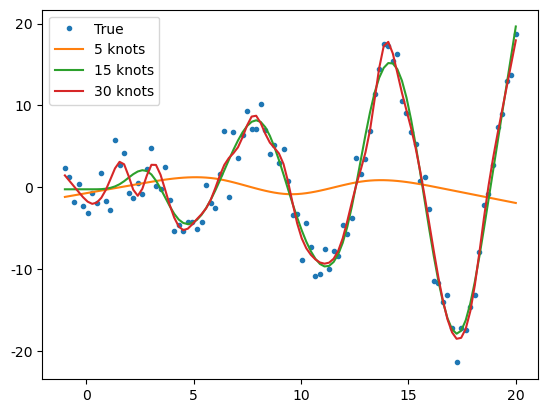

In [448]:
plt.plot(x, y, ls='', marker='.', label='True')

for n_knots in [5, 15, 30]:
    model = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=n_knots)
    y_est = model.predict(x)
    plt.plot(x, y_est,label=str(n_knots)+' knots')
    
plt.legend(loc='best')
plt.show()

# Регуляризация

In [415]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Ridge
from sklearn.metrics import mean_squared_error

In [416]:
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"
df = pd.read_csv(URL, header=None)

X = df.loc[:100, 5]
y = df.loc[:100, 13]

X_reshaped = X[:, np.newaxis]
y_reshaped = y[:, np.newaxis]


def draw(y_pred, X=X, y=y, X_reshaped=X_reshaped):
    plt.plot(X, y, 'o')
    plt.plot(X_reshaped, y_pred, color="red")
    plt.show()

### Linear Regression

MSE: 9.76285367441297


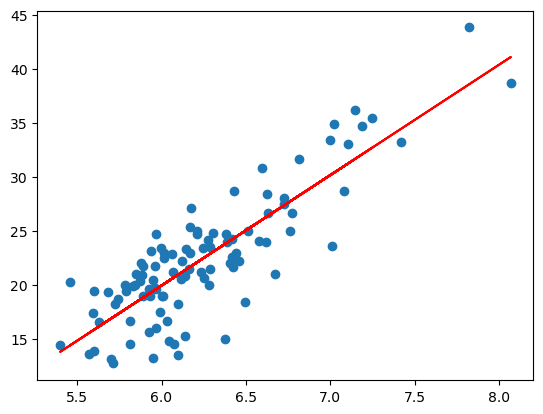

In [422]:
linear_regression = LinearRegression()

linear_regression.fit(X_reshaped, y_reshaped)

y_pred = linear_regression.predict(X_reshaped)

mse = mean_squared_error(y_reshaped, y_pred)
print(f"MSE: {mse}")

draw(y_pred)

### L1

Регуляризация L1(Lasso) борется с переобучениями, уменьшая коэффициенты модели до 0.

Когда мы назначаем признак с весом 0, мы умножаем значения признаков на 0, исключая значение этого элемента. Если входные функции нашей модели имеют вес ближе к 0, наша норма L1 будет редкой. Выбор входных функций будет иметь вес, равный нулю, а остальные будут ненулевыми.

Предсказываем цены на жилье, имея признаки:
- Улица - подъезд к дороге,
- Район - местоположение недвижимости,
- Доступность - транспортный доступ,
- Год постройки - год постройки дома,
- Комнаты - количество комнат,
- Кухни - количество кухонь,
- Камины - количество каминов в доме.

Предсказывая стоимость дома, интуиция говорит нам, что различные функции ввода не будут иметь одинакового влияния на цену. Например, весьма вероятно, что район или количество комнат оказывают более высокое влияние на цену недвижимости, чем количество каминов.

Таким образом, **L1 припишет каминам нулевой вес**, потому что он не оказывает существенного влияния на цену. Мы можем ожидать, что **району и номерам будут присвоены ненулевые веса**, потому что эти особенности значительно влияют на цену недвижимости.

$Loss = \frac{1}{N} \sum\limits_{i=1}^N (\hat{Y} - Y)^2 + \lambda\sum\limits_{i=1}^N |\theta_i|$

MSE: 34.709124595627884
Model Coefficients: 0.0


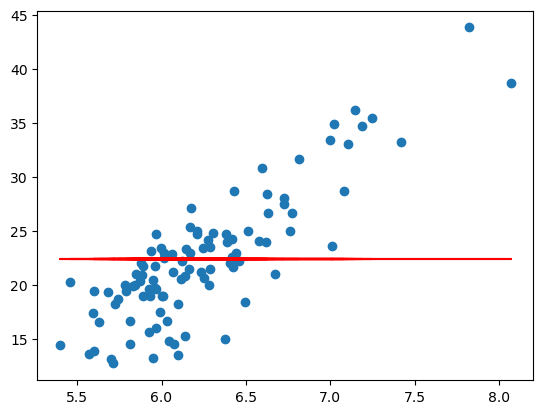

In [424]:
lasso = Lasso(alpha=100)

lasso.fit(X_reshaped, y_reshaped)

y_pred = lasso.predict(X_reshaped)

mse = mean_squared_error(y_reshaped, y_pred)
print(f"MSE: {mse}")
print(f"Model Coefficients: {lasso.coef_[0]}")

draw(y_pred)

### L2

Регуляризация L2(Ridge) борется с переобучения, заставляя веса быть маленькими, но не делая их точно 0.

Таким образом, если мы снова прогнозируем цены на жилье, это означает, что менее важные признаки для прогнозирования цены на жилье все равно окажут некоторое влияние на окончательный прогноз, но он будет небольшим.


$Loss = \frac{1}{N} \sum\limits_{i=1}^N (\hat{Y} - Y)^2 + \lambda\sum\limits_{i=1}^N \theta_i^2$

MSE: 25.96309109305436
Model Coefficients: 1.9854252350650399


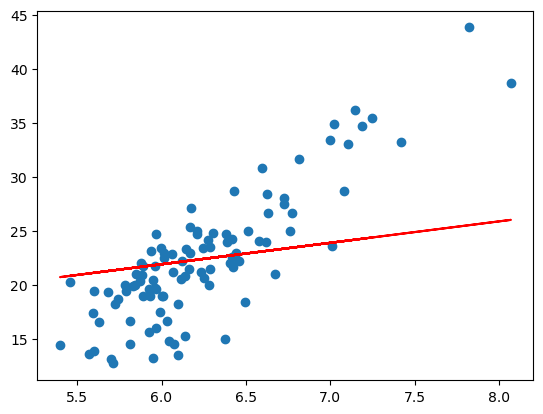

In [425]:
ridge = Ridge(alpha=100)
ridge.fit(X_reshaped, y_reshaped)
y_pred = ridge.predict(X_reshaped)

mse = mean_squared_error(y_reshaped, y_pred)
print(f"MSE: {mse}")
print(f"Model Coefficients: {ridge.coef_[0][0]}")

draw(y_pred)